In [6]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import h5py
import numpy as np
from tqdm.notebook import tqdm
from utils import get_outputs_labels, get_correct_idxs, get_incorrect_idxs, propci_wilson_cc
# How many corruptions per dataset/model combination
datasets = ['imnet', 'flowers102']
models = ['inceptionv3', 'resnet18', 'MobileNetV2', 'resnet50',]
#orig_idx = 50
#tta_policy = 'pil'
orig_idx = 12
tta_policy = 'five_crop_hflip_scale'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
results = []
for dataset in datasets:
    for model in tqdm(models):
        path = '../' + dataset + '/' + tta_policy + '/model_outputs/val/' + model + '.h5'
        outputs, labels = get_outputs_labels(path)
        stta_preds = np.mean(outputs, axis=0)
        orig_preds = outputs[orig_idx,:,:]
        stta_correct_idxs = get_correct_idxs(stta_preds, labels)
        stta_incorrect_idxs = get_incorrect_idxs(stta_preds, labels)
        orig_correct_idxs = get_correct_idxs(orig_preds, labels)
        orig_incorrect_idxs = get_incorrect_idxs(orig_preds, labels)
        corruptions = set(stta_incorrect_idxs).intersection(orig_correct_idxs)
        corrections = set(stta_correct_idxs).intersection(orig_incorrect_idxs)
        results.append({'dataset': dataset, 'model': model, 
                        'n_changed': len(corruptions), 'change_type': 'Corruptions'})
        results.append({'dataset': dataset, 'model': model, 
                        'n_changed': len(corrections), 'change_type': 'Corrections'})
results_df = pd.DataFrame(results)
results_df.to_csv('../results/expanded_corruptions_corrections')

In [2]:

model_name_dict = {'resnet18': 'ResNet-18', 'resnet50': 'ResNet-50', 
                   'MobileNetV2': 'MobileNetV2', 'inceptionv3': 'InceptionV3',
                  }
dataset_name_dict = {'imnet': 'ImageNet', 'flowers102': 'Flowers-102', 'birds200': 'Birds200'}

In [35]:
def grouped_barplot(df, cat,subcat, val , err, ax):
    plt.sca(ax)
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    print(ax)
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width,
                label="{}".format(gr), yerr=dfg[err].values)
    plt.xlabel(cat)
    plt.ylabel(val)
    plt.xticks(x, u)
    #plt.legend()
    #plt.show()

/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

AxesSubplot(0.125,0.125;0.352273x0.755)
AxesSubplot(0.547727,0.125;0.352273x0.755)


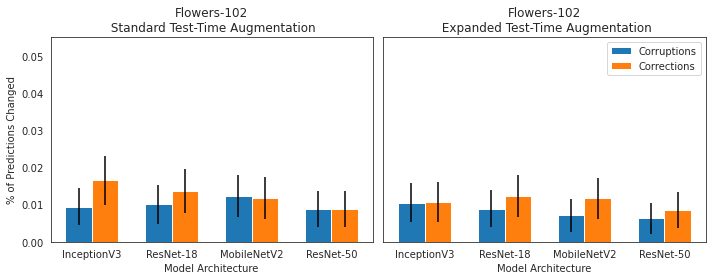

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
datasets = ['imnet', 'flowers102']
models = ['inceptionv3', 'resnet18', 'MobileNetV2', 'resnet50',]
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for i in range(2):
    dataset = 'imnet'
    path = '../results/expanded_corruptions_corrections'
    ax = axs[i]
    if i < 2:
        dataset = 'flowers102'
    if i % 2 == 0:
        path = '../results/corruptions_corrections'
    results_df = pd.read_csv(path)
    ds_results = results_df[results_df['dataset'] == dataset]
    if dataset == 'imnet':
        n_samples = 50000
    elif dataset == 'flowers102':
        ax.set_ylim(0, .0175)
        n_samples = 6149
        
    ax.set_ylim(0, .055)
    ds_results['pct_changed'] = ds_results['n_changed']/n_samples
    ds_results['ci_l'] = ds_results.apply(lambda row: propci_wilson_cc(row.n_changed, n_samples)[0],
                                          axis=1)
    ds_results['ci_u'] = ds_results.apply(lambda row: propci_wilson_cc(row.n_changed, n_samples)[1],
                                              axis=1)
    ds_results['error'] = ds_results['ci_u'] - ds_results['ci_l']    
    
    cat = 'model'
    subcat = 'change_type'
    err = 'error'
    val = 'pct_changed'
    grouped_barplot(ds_results, cat, subcat, val, err, ax)
    
    
    
    
    ax.set_ylabel("% of Predictions Changed")
    if i % 2 == 1:
        ax.set_yticklabels([])
        ax.set_ylabel("")

    ax.set_xlabel("Model Architecture")
    ax.set_xticklabels([model_name_dict[i] for i in models])
    if i % 2 == 0:
        ax.set_title(dataset_name_dict[dataset] + "\n Standard Test-Time Augmentation")
    else:
        ax.set_title(dataset_name_dict[dataset] + "\n Expanded Test-Time Augmentation")
    if i % 2 == 1:
        plt.legend()
plt.tight_layout()

AxesSubplot(0.125,0.125;0.775x0.755)


/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

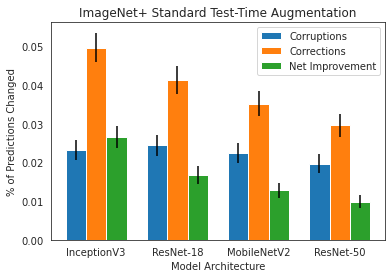

In [58]:
dataset = 'imnet'
path = '../results/corruptions_corrections'
results_df = pd.read_csv(path)
ds_results = results_df[results_df['dataset'] == dataset]
n_samples = 50000
fig, ax = plt.subplots(1)
ds_results['pct_changed'] = ds_results['n_changed']/n_samples
ds_results['ci_l'] = ds_results.apply(lambda row: propci_wilson_cc(row.n_changed, n_samples)[0],
                                          axis=1)
ds_results['ci_u'] = ds_results.apply(lambda row: propci_wilson_cc(row.n_changed, n_samples)[1],
                                          axis=1)
ds_results['error'] = ds_results['ci_u'] - ds_results['ci_l']    

for model in models:
    n_corrupted = ds_results[(ds_results['model'] == model) & 
                           (ds_results['change_type'] == 'Corruptions')]['n_changed']
    n_corrupted = list(n_corrupted)[0]
    n_corrected = ds_results[(ds_results['model'] == model) & 
                           (ds_results['change_type'] == 'Corrections')]['n_changed']
    n_corrected = list(n_corrected)[0]
    n_changed = n_corrected - n_corrupted
    pct_changed = n_changed/50000
    ci_l, ci_u = propci_wilson_cc(n_changed, 50000)
    
    ds_results = ds_results.append({'dataset': 'imnet', 'n_changed': n_changed, 
                                    'change_type': 'Net Improvement',
                            'pct_changed':pct_changed,
                            'model': model, 'error': ci_u - ci_l}, ignore_index=True)

cat = 'model'
subcat = 'change_type'
err = 'error'
val = 'pct_changed'
grouped_barplot(ds_results, cat, subcat, val, err, ax)
    
    
    
    
ax.set_ylabel("% of Predictions Changed")

ax.set_xlabel("Model Architecture")
ax.set_xticklabels([model_name_dict[i] for i in models])
ax.set_title(dataset_name_dict[dataset] + "+ Standard Test-Time Augmentation")
plt.legend()

In [50]:
list(n_corrupted)[0]

[1159]

In [55]:
for model in models:
    n_corrupted = ds_results[(ds_results['model'] == model) & 
                           (ds_results['change_type'] == 'Corruptions')]['n_changed']
    n_corrupted = list(n_corrupted)[0]
    n_corrected = ds_results[(ds_results['model'] == model) & 
                           (ds_results['change_type'] == 'Corrections')]['n_changed']
    n_corrected = list(n_corrected)[0]
    n_changed = n_corrected - n_corrupted
    pct_changed = n_changed/50000
    ci_l, ci_u = propci_wilson_cc(n_changed, 50000)
    
    ds_results = ds_results.append({'dataset': 'imnet', 'n_changed': n_changed, 'change_type': 'Net',
                            'pct_changed':pct_changed,
                            'model': model, 'error': ci_u - ci_l}, ignore_index=True)

In [4]:
# Relationship between model size and accuracy
# x axis = model size y axis = average agreement of augmentations with one another
# do this for standard + flowers, standard + imnet, expanded + flowers, expanded + imnet
model_params_map = {'resnet18': 11000000, 'resnet50': 23000000, 'MobileNetV2': 3400000,
                   'inceptionv3': 23885392}
model_results = []
datasets=['flowers102']
tta_policy = 'pil'

for dataset in datasets:
    for model in tqdm(models):
        path = '../' + dataset + '/' + tta_policy + '/model_outputs/val/' + model + '.h5'
        outputs, labels = get_outputs_labels(path)
        print("loaded output labels")
        stta_preds = np.mean(outputs, axis=0)
        orig_preds = outputs[orig_idx,:,:]
        orig_correct_idxs = get_correct_idxs(orig_preds, labels)
        orig_acc = len(orig_correct_idxs)/len(labels)
        
        # iterate over all augmentations
        avg_ambiguity = 0
        n_augs = len(outputs)
        idxs = np.arange(n_augs)
        for aug_idx in tqdm(range(n_augs)):
            aug_preds = outputs[aug_idx]
            other_aug_preds = np.mean(outputs[idxs != aug_idx], axis = 0)
            aug_labels = np.argmax(aug_preds, axis=1)
            other_aug_labels = np.argmax(other_aug_preds, axis=1)
            n_agree = len(np.where(aug_labels == other_aug_labels)[0])
            ambiguity = n_agree/len(aug_labels)
            avg_ambiguity += (1/n_augs)*ambiguity
        
        model_results.append({'model': model, 'dataset': dataset, 'orig_acc': orig_acc, 
                        'ambiguity': avg_ambiguity})
models_df = pd.DataFrame(model_results)
models_df.to_csv('pil_model_results')

loaded output labels


KeyboardInterrupt: 

<AxesSubplot:xlabel='orig_acc', ylabel='ambiguity'>

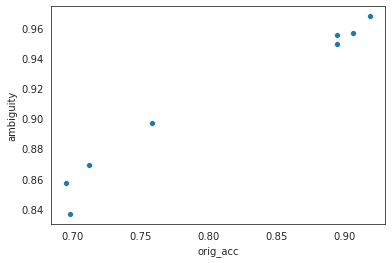

In [19]:
import seaborn as sns
sns.set_style('white')
sns.scatterplot(x='orig_acc', y='ambiguity', data=models_df)

In [17]:
model_results

[{'model': 'inceptionv3',
  'dataset': 'flowers102',
  'orig_acc': 0.8942917547568711,
  'ambiguity': 0.9495094053233587},
 {'model': 'resnet18',
  'dataset': 'flowers102',
  'orig_acc': 0.8944543828264758,
  'ambiguity': 0.9557001138396487},
 {'model': 'MobileNetV2',
  'dataset': 'flowers102',
  'orig_acc': 0.9060009757684176,
  'ambiguity': 0.9570445058817151},
 {'model': 'resnet50',
  'dataset': 'flowers102',
  'orig_acc': 0.9185233371279883,
  'ambiguity': 0.9679785330948121}]